## Подключение библиотек

In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import psycopg2

## Подключение к БД. Скачивание данных и сохранение их в формате csv

In [11]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-05-23 19:37:24--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-05-23 19:37:25 (847 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



In [12]:
!sudo apt update && sudo apt install --yes python3 python3-pip && \
!pip3 install psycopg2-binary

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3,202 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1,345 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:14 h

In [13]:
conn = psycopg2.connect("""
    host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
    port=6432
    sslmode=verify-full
    dbname=db_clients
    user=mlhs_student
    password=mlhs_student
    target_session_attrs=read-write
""")

# получаем сырые данные
# напишите код
query = '''
SELECT * from public.credit_scoring
        '''


In [105]:
raw_data = pd.read_sql_query(query, con = conn)

<ipython-input-105-b29b82c53af5>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  raw_data = pd.read_sql_query(query, con = conn)


In [106]:
raw_data.head(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b


In [45]:
#Выгружаем данные в csv
raw_data.to_csv('raw_data_scoring.csv')

## EDA

In [107]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   135155 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfDependents                    146076 non-null  float64
 10  RealEstateLoansOrLines                150000 non-null  object 
 11  

В датасете 150 000 наблюдений и 12 признаков. В 3 признаках присутствуют пропуски


In [108]:
raw_data.duplicated().sum()

634

In [109]:
raw_data.query('age==age and MonthlyIncome==MonthlyIncome and NumberOfDependents==NumberOfDependents').duplicated().sum()

89

In [130]:
temp=raw_data.query('age==age and MonthlyIncome==MonthlyIncome and NumberOfDependents==NumberOfDependents').duplicated()


In [131]:
temp=pd.DataFrame(temp)


In [137]:
index_del=temp[temp[0]==True].index
data=raw_data.drop(index=index_del)

In [138]:
data.query('age==age and MonthlyIncome==MonthlyIncome and NumberOfDependents==NumberOfDependents').duplicated().sum()

0

Потенциально возможны дубликаты, но туда попадают только строки с пропусками. А в остальных значениях как раз много совпадений. Для большинства нет просрочек, иждивенцев

In [139]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,149911.000000,149911.000000,135066.000000,149911.000000,149911.000000,1.201800e+05,149911.000000,149911.000000,149911.000000,145987.000000
mean,0.066866,6.051702,52.312033,0.419322,353.214646,6.674619e+03,8.456991,0.264163,0.238568,0.757684
std,0.249791,249.829462,14.758593,4.171235,2038.405192,1.438908e+04,5.144516,4.147555,4.133337,1.115269
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029898,41.000000,0.000000,0.175433,3.400000e+03,5.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154161,52.000000,0.000000,0.366733,5.400000e+03,8.000000,0.000000,0.000000,0.000000
75%,0.000000,0.558637,63.000000,0.000000,0.869267,8.250000e+03,11.000000,0.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,98.000000,20.000000


* SeriousDlqin2yrs - не сбалансировано. Клиентов, имеющих просрочу меньше, 
чем тех, которые платили во время, как миниму, 75% клиентов не имели просрочки

* RevolvingUtilizationOfUnsecuredLines - балансы клиентов скошены вправо

* В данных возраста age есть некорректные значения максимальное 109 под вопросом минимальное в 0 точно ошибочно. При этом 75% клиентов не младше 41 лет

* У большинства клиентов нет иждевенцев и просрочек

In [140]:
data['SeriousDlqin2yrs'].value_counts(normalize=True)

0    0.933134
1    0.066866
Name: SeriousDlqin2yrs, dtype: float64

<Axes: >

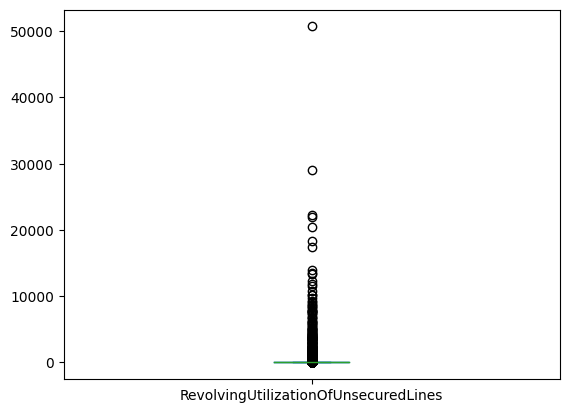

In [141]:
data['RevolvingUtilizationOfUnsecuredLines'].plot(kind='box')

In [142]:
#Посмотрим нулевые значения в трех разных полях у одних и тех же клиентов или нет
temp=data.query('age!=age and MonthlyIncome!=MonthlyIncome and NumberOfDependents!=NumberOfDependents').shape[0]
temp

376

In [143]:
#Пересечение небольшое
print(f'При удалении просто нулевых данных потеряем\
 {(data.age.isna().sum()+data.MonthlyIncome.isna().sum()+data.NumberOfDependents.isna().sum()-2*temp)/data.shape[0]:.1%}')

При удалении просто нулевых данных потеряем 31.9%


In [144]:
#Посмотрим распределение возраста, без нулевых значений
data.query('age!=0')['age'].describe()

count    135065.000000
mean         52.312420
std          14.757961
min          21.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

In [145]:
print(f'Количество клиентов с возрастом = 0 - {data.query("age==0").shape[0]}')

Количество клиентов с возрастом = 0 - 1


У нас есть возрастная группа попробуем по ней восстановить возраст. Посомтрим сколько таких групп

In [146]:
data['GroupAge'].value_counts(normalize=True)

d    0.315300
e    0.286357
c    0.283215
b    0.115122
a    0.000007
Name: GroupAge, dtype: float64

In [147]:
#Посмотрим минимальное и максимальное значение в каждой группе
data.pivot_table(index='GroupAge',values='age',aggfunc=['min','max'])

,min,max
,age,age
GroupAge,,
a,0.0,0.0
b,21.0,34.0
c,35.0,49.0
d,50.0,64.0
e,65.0,109.0


In [148]:
data.query("age==0")['SeriousDlqin2yrs']

41655    0
Name: SeriousDlqin2yrs, dtype: int64

В будущем можно будет удалить данные с 0 возрастом

In [149]:
#Посмотрим какие группы в пропусках указаны
data.query('age!=age')['GroupAge'].value_counts(normalize=True)

e    1.0
Name: GroupAge, dtype: float64

In [150]:
data.query('age!=age')['SeriousDlqin2yrs'].value_counts(normalize=True)

0    0.932637
1    0.067363
Name: SeriousDlqin2yrs, dtype: float64

данные со значением целевой переменной распределены также,как и во всем датасете. В идеале проверить и по другим переменным. Но в общем, выглядит так, что можно удалить было бы значения, но попробуем восстановить

<Axes: >

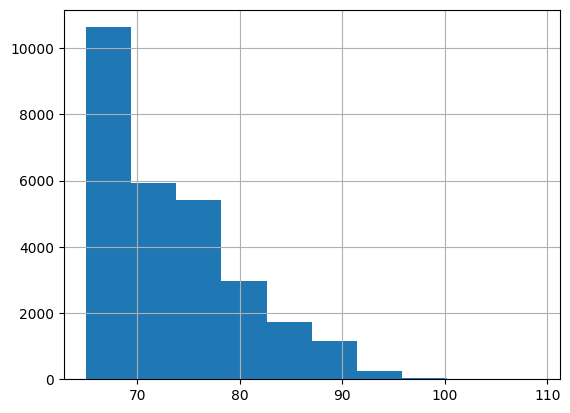

In [151]:
data.query('GroupAge=="e"')['age'].hist()

In [152]:
#Действуем из предположения, что возрастную группу заполняли нормально, а не ставили всем с пропусками группу e. 
#Можно было бы поисследовать, но некогда)
#Заполним медианным значением, так как медина устойчивее к выбросам
data['age']=data['age'].fillna(data.query('GroupAge=="e"')['age'].median())

In [153]:
data['GroupAge'].value_counts(normalize=True)

d    0.315300
e    0.286357
c    0.283215
b    0.115122
a    0.000007
Name: GroupAge, dtype: float64

In [154]:
data.query('MonthlyIncome!=MonthlyIncome')['SeriousDlqin2yrs'].value_counts(normalize=True)

0    0.943863
1    0.056137
Name: SeriousDlqin2yrs, dtype: float64

In [155]:
data.query('MonthlyIncome!=MonthlyIncome')['GroupAge'].value_counts(normalize=True)

e    0.370018
d    0.330329
c    0.214490
b    0.085164
Name: GroupAge, dtype: float64

In [156]:
data['NumberOfOpenCreditLinesAndLoans'].describe()

count    149911.000000
mean          8.456991
std           5.144516
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [157]:
data.query('MonthlyIncome!=MonthlyIncome')['NumberOfOpenCreditLinesAndLoans'].describe()

count    29731.000000
mean         7.216071
std          4.842720
min          0.000000
25%          4.000000
50%          6.000000
75%         10.000000
max         45.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [158]:
data['NumberOfOpenCreditLinesAndLoans'].describe()

count    149911.000000
mean          8.456991
std           5.144516
min           0.000000
25%           5.000000
50%           8.000000
75%          11.000000
max          58.000000
Name: NumberOfOpenCreditLinesAndLoans, dtype: float64

In [159]:
data=data.drop(index=data.query("age==0").index)